In [1]:
# Importación de paquetes.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
%matplotlib inline

C:\Users\marco\AppData\Local\Temp\ipykernel_23972\1865039913.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
# Función para aplicar suavizado utilizando el filtro Savitzky-Golay en una región específica
def apply_savgol_smoothing(y, transition_index, window_length1, polyorder1, window_length2, polyorder2):
    y_smooth = np.copy(y)
    y_smooth[:transition_index+1] = ss.savgol_filter(y[:transition_index+1], window_length=window_length1, polyorder=polyorder1)
    y_smooth[transition_index:] = ss.savgol_filter(y[transition_index:], window_length=window_length2, polyorder=polyorder2)
    return y_smooth

In [3]:
# Función para aplicar suavizado con kernel gaussiano en una región específica
def apply_gaussian_smoothing(y, transition_index, sigma1, sigma2):
    y_smooth = np.copy(y)
    y_smooth[:transition_index+1] = gaussian_filter1d(y[:transition_index+1], sigma=sigma1, order=0)
    y_smooth[transition_index:] = gaussian_filter1d(y[transition_index:], sigma=sigma2, order=0)
    return y_smooth

In [4]:
# Función para aplicar suavizado con kernel gaussiano en una región específica
def apply_mix_smoothing(y, transition_index, window_length1, polyorder1, sigma2):
    y_smooth = np.copy(y)
    y_smooth[:transition_index+1] = ss.savgol_filter(y[:transition_index+1], window_length=window_length1, polyorder=polyorder1)
    y_smooth[transition_index:] = gaussian_filter1d(y[transition_index:], sigma=sigma2, order=0)
    return y_smooth

In [5]:
# Importación de datos TG de Laponita funcionalizada.
df1 = pd.read_csv('./nuevaCarpeta/Laponite_Er_TG.txt',sep='\t',header=None,names=['Temperatura','TG','Heat Flow','H2O'], 
        usecols=['Temperatura','TG','Heat Flow','H2O'],decimal=',')

In [6]:
x = df1["Temperatura"].values
y = df1["TG"].values

In [7]:
# Filtrado de datos.
minim = min(df1["Temperatura"].values)

In [8]:
a = df1.loc[df1["Temperatura"]==minim].index[0]

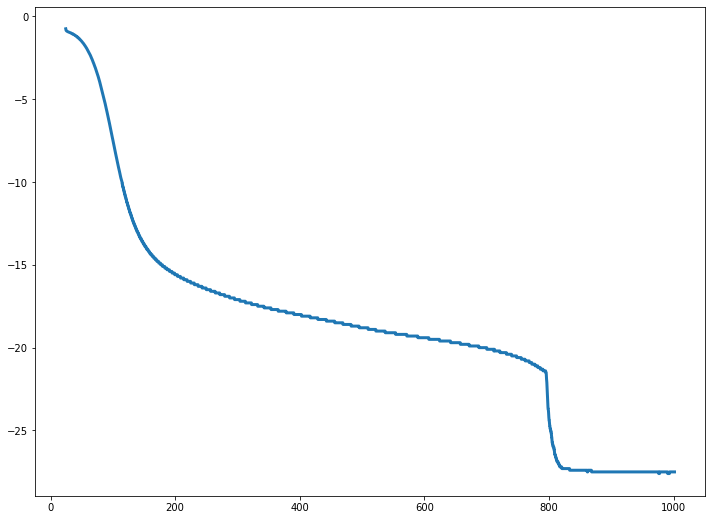

In [9]:
plt.figure(figsize=(12, 9))
plt.plot(x[a:], y[a:], linewidth=3, label="y")

In [10]:
x = x[a:]
y = y[a:]

In [11]:
# Interpolación de los puntos del eje x.
x_interpolated = np.linspace(x.min(), x.max(), len(x))
y_interpolated = interp1d(x, y)(x_interpolated)

In [12]:
def calculate_derivative(x, y):
    dx = np.gradient(x)  # Calcular el espaciado entre puntos en el eje x
    dy = np.gradient(y)  # Calcular la diferencia entre puntos en el eje y
    derivative = dy / dx  # Calcular la derivada punto por punto
    return derivative
derivative_raw = calculate_derivative(x_interpolated, y_interpolated)
print(derivative_raw)

[-0.30657386 -0.1954011  -0.07592589 ...  0.          0.
  0.        ]


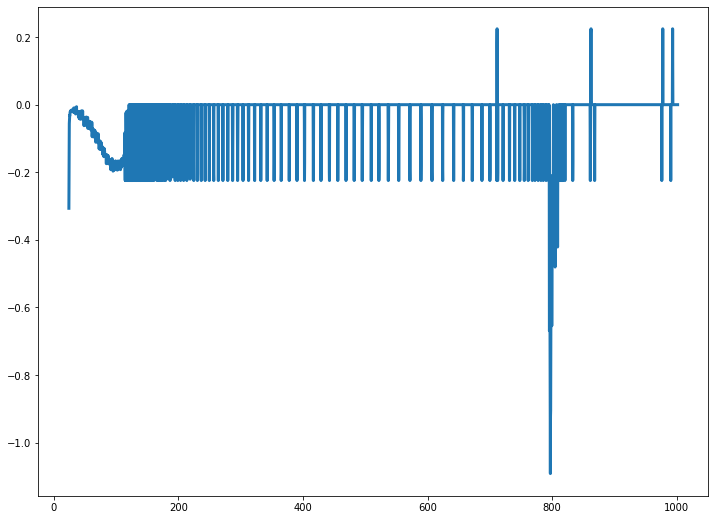

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated[:], derivative_raw[:], linewidth=3, label="y_dev_smooth")

In [14]:
end_start = np.where(x_interpolated > 110)[0][0]
print(end_start)

385


In [15]:
# Definir las regiones donde se aplicará el suavizado
transition_index = end_start
#window_length1=300, polyorder1=5
# Aplicar suavizado en cada región con diferentes parámetros
y_smooth =  gaussian_filter1d(y_interpolated, sigma=30, order=0)
#y_smooth =  ss.savgol_filter(y_interpolated, window_length=250, polyorder=3)
#apply_gaussian_smoothing(y_interpolated, transition_index,sigma1=20,sigma2=20)

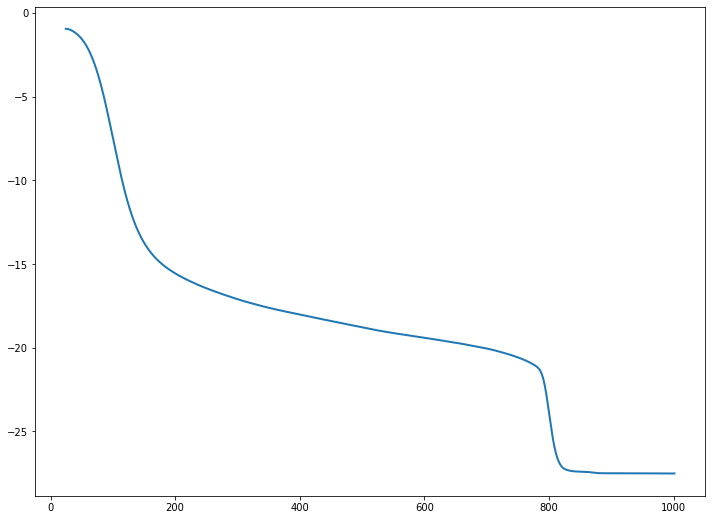

In [16]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated, y_smooth, linewidth=2, label="y_smoothed")

In [17]:
derivative = calculate_derivative(x_interpolated, y_smooth)
print(derivative)

[-5.47798904e-04 -8.21454943e-04 -1.36837466e-03 ...  1.65954175e-04
  9.99093536e-05  6.67186941e-05]


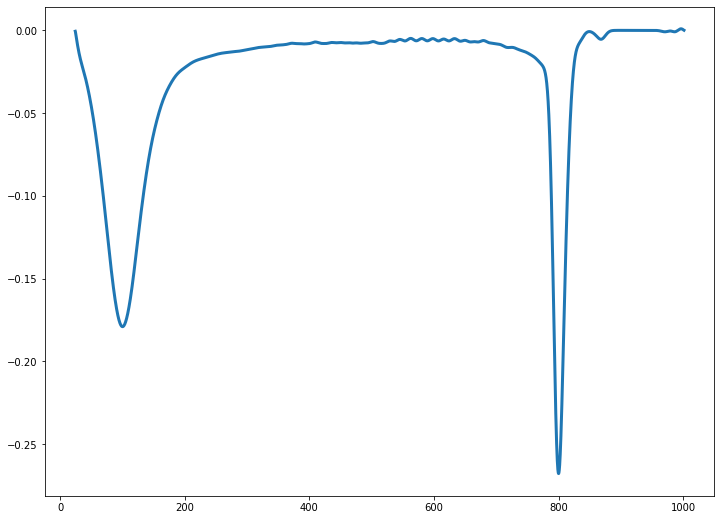

In [18]:
plt.figure(figsize=(12, 9))
plt.plot(x_interpolated, derivative, linewidth=3, label="y_dev_smooth")

In [19]:
y_dev_smooth = derivative
a = np.where(y_dev_smooth < 0)[0][0]  # Filtrado de datos
print(a)

0


In [20]:
print(x_interpolated[a])
print(y_dev_smooth[a])

24.4
-0.0005477989040458541


In [21]:
# Exportación de datos DTG de Laponita funcionalizada.
df2 = pd.DataFrame({"Temperatura":x_interpolated,"TG_smooth":y_smooth,"TG_dev":y_dev_smooth})
df2.to_csv('./nuevaCarpeta/Laponita_Er_TG_smooth.txt',sep='\t',index=False,decimal=',')

In [22]:
#x_interpolated[:], derivative[:]
df3 = pd.DataFrame({"Temperatura":x,"DTG_raw":derivative_raw[:],"DTG_processed":y_dev_smooth})
df3.to_csv('./nuevaCarpeta/ejemploLaponitaFuncionalizada.txt',sep='\t',index=False,decimal=',')

In [23]:
b = np.where(x_interpolated>184.2)[0][0] #filtrado de datos
b

718

In [24]:
print(x_interpolated[b])
print(y_dev_smooth[b])

184.2847048096649
-0.028162833981579514


In [25]:
min_temp_1 = np.where(y_dev_smooth == min(y_dev_smooth[a:b]))
print(x_interpolated[min_temp_1])
print(y_dev_smooth[min_temp_1])

[100.33410075]
[-0.17903243]


In [26]:
# Integración numérica con la regla trapezoidal.
resultado_original = np.trapz(y_dev_smooth[a:b],x_interpolated[a:b])
resultado_original

-14.206799776301644

In [33]:
# Cálculo del error
a_e = np.where(x>(24.4-0.1))[0][0]
b_e = np.where(x>(184.2+0.5))[0][0]
resultado_desplazado = np.trapz(y_dev_smooth[a_e:b_e], x_interpolated[a_e:b_e])
print("resultado desplazado:",resultado_desplazado)
error_integral = np.abs(resultado_original - resultado_desplazado)
print("error_integral:",error_integral)

resultado desplazado: -14.109296339120188
error_integral: 0.09750343718145515


In [28]:
c = np.where(x_interpolated>780.7)[0][0] #filtrado de datos
c

3397

In [29]:
d = np.where(x_interpolated>824.6)[0][0] #filtrado de datos
d

3594

In [30]:
min_temp_2 = np.where(y_dev_smooth == min(y_dev_smooth[c:d]))
print(x_interpolated[min_temp_2])
print(y_dev_smooth[min_temp_2])

[799.99669478]
[-0.26779281]


In [31]:
# Integración numérica con la regla trapezoidal.
resultado_original_hidrox = np.trapz(y_dev_smooth[c:d],x_interpolated[c:d])
resultado_original_hidrox

-6.080628362427558

In [32]:
# Cálculo del error
c_e = np.where(x>(780.7-0.5))[0][0]
d_e = np.where(x>(824.6+0.5))[0][0]
resultado_desplazado_hidrox = np.trapz(y_dev_smooth[c_e:d_e], x_interpolated[c_e:d_e])
print("resultado desplazado:",resultado_desplazado_hidrox)
error_integral_hidrox = np.abs(resultado_original_hidrox - resultado_desplazado_hidrox)
print("error_integral:",error_integral_hidrox)

resultado desplazado: -6.060573531636637
error_integral: 0.020054830790921407
